# Particle Filtering for Sequential Bayesian Inference

## Introduction
In this notebook, we produce an implementation of the particle filtering methods discussed in the accompanying article. In particular, we introduce the *bearings-only tracking* problem, a nonlinear non-Gaussian sequential inference problem. Next, we implement sequential importance sampling (SIS) to solve bearings-only tracking and observe the method's limitations. Finally, we achieve a respectable solution to our problem using the bootstrap filter. 

## The Problem 
### Statement
The bearings-only tracking problem is as follows. Suppose a plane begins at $x_0 = (0.01, 0.95)$ with a velocity $v_0=(0.02, -0.013)$ and for $50$ time steps moves according to the following dynamical system. 
\begin{align}
v_{t+1} &\sim \mathcal{N}(v_t, \Sigma_v)\\
x_{t+1} & = x_t + v_t
\end{align}

where $\Sigma_v = 10^{-6}I_2$. At each time $t$, we receive a noisy measurement of the plane's bearing, that is 

\begin{equation} y_t = \mathrm{angle}(x_t) + w_t \end{equation}

where $w_t \sim \mathcal{N}(0, \sigma=0.005)$.

Our goal is to infer $p(x_{0:50}, v_{0:50}| y_{1:50})$. 

### Code
First, we do our imports and set a random seed. 

In [1]:
import numpy as np
import scipy.stats as sp_stats
import scipy.special as sp_special
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import math

np.random.seed(3)

Next, we parametrize our prior. 

In [2]:
# number of time steps
num_samples = 50
# number of particles
num_particles = 100
# Parameters of the prior 
x0 = [0.01, 0.95]
v0 = [0.02, -0.013]
vx_var, vy_var = (1.0/1e6, 1.0/1e6)
v_cov = [[vx_var, 0], [0, vy_var]]
measurement_noise = 0.005

The `BearingsData` class performs the following functions 
1. Simulates a ground-truth state $(x_{0:50}, v_{0:50})$ and accompanying measurements $y_{1:50}$.  
2. Provides plotting functions. 
3. Gives us a `__getitem__` function, which allows us to sequentially retrieve datapoints. 

In [3]:
class BearingsData(object): 
    def __init__(self, num_samples):         
        # Simulates velocities 
        v_matrix = np.zeros((num_samples, 2))
        v_matrix[0, :] = np.random.multivariate_normal(v0, v_cov)
        for i in range(1, num_samples): 
            v_matrix[i, :] = np.random.multivariate_normal(v_matrix[i-1, :], v_cov)
        self.v = v_matrix 
        
        # Calculates positions 
        x = np.cumsum(v_matrix, axis=0) + x0 - v_matrix # subtract v_matrix because x_t depends on v_{t-1}
        self.x = x
        
        # Calculates bearings 
        noise_vector = np.random.multivariate_normal(np.zeros(num_samples),
                                                    (measurement_noise**2) * np.identity(num_samples))
        y = np.arctan(x[:, 1]/x[:, 0]) + noise_vector
        self.y = y 
    
    """Plots trajectory and bearings"""
    def plot(self): 
        plt.scatter(self.x[:, 0], self.x[:, 1])
        
        y = np.arctan(self.x[:, 1]/self.x[:, 0])
        
        for yt in self.y: 
            dx = math.cos(yt) * .5
            dy = math.sin(yt) * .5
            plt.plot([0., dx], [0., dy], color="red", alpha=0.3)
        
        plt.show() 
    
    """Plots inferences overlayed on ground-truth trajectory and measurements"""
    def plot_inferences(self, inferences):
        plt.plot(self.x[:, 0], self.x[:, 1], color="black", lw=2, 
                path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])
        
        for yt in self.y: 
            dx = math.cos(yt) * .5
            dy = math.sin(yt) * .5
            plt.plot([0., dx], [0., dy], color="red", alpha=0.3)

        for x in inferences: 
            plt.scatter(x[:, 0], x[:, 1])
        plt.show()

    """Retrieves position, velocity, and measurement at time t"""
    def __getitem__(self, idx): 
        if idx < self.x.shape[0]: 
            xt = self.x[idx, :]
            vt = self.v[idx, :]
            yt = self.y[idx]
            return xt, vt, yt
        else: 
            raise IndexError('high enough')   

Here, we simulate one run of the data-generating process. 

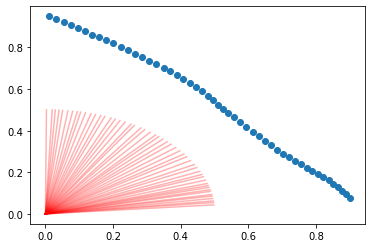

In [4]:
data = BearingsData(num_samples)
data.plot()

## SIS

In this section, we implement SIS in order to infer the hidden-state given the measurements of the data we generated in the last section. 
Throughout our calculations, we use log probabilities for numerical stability.

The following defines the Markov transition kernel from state $(x_t, v_t)$ to $(x_{t+1}, v_{t+1})$. Note that the kernel only takes velocities as input: we assume that the deterministic relation $x_{t+1} = x_t + v_t$ is satisfied. 

In [5]:
"""Markov transition kernel""" 
def transition_kernel(v1, v2): 
    v2_dist = sp_stats.multivariate_normal(mean=v1, cov=v_cov)
    return v2_dist.logpdf(v2)

Next, we define the marginal distribution $p(y_t| x_t, v_t)$. Note that $p(y_t|x_t, v_t)$ does not depend on $v_t$. 

In [6]:
"""Probability of measurement y given state xt, vt"""
def measurement_prob(yt, xt): 
    error = np.arctan(xt[1]/xt[0]) - yt
    return sp_stats.norm.logpdf(error, scale=measurement_noise)

We represent our particles as a dictionary with keys {"locations", "velocities", "weight", "prior_prob"}. We store all the particles in a list. 

The following function computes a particle filter step, outputting particles with unnormalized weights. It takes as input particles $\{(x_{0:t}^{(i)}, v_{0:t}^{(i)})\}$, draws each $(x_{t+1}^{(i)}, v_{t+1}^{(i)})$, and updates weights and prior probabilities accordingly. Since we reuse this function when implementing the bootstrap filter, we add the `selection` argument that modifies how the weights are updated. 

In [7]:
def particle_filter_step(particles, yt, selection=False): 
    new_particles = []
    for i in range(len(particles)): 
        
        particle = particles[i]
        prev_x = np.squeeze(particle["locations"][-1:, :])
        prev_v = np.squeeze(particle["velocities"][-1:, :])
        
        vt = np.random.multivariate_normal(prev_v, v_cov)
        xt = prev_x + prev_v 
        new_particle = {}
        new_particle["prior_prob"] = particle["prior_prob"] + transition_kernel(prev_v, vt)
        if selection: 
            new_particle["weight"] = measurement_prob(yt, xt)
        else: 
            new_particle["weight"] = particle["weight"] + measurement_prob(yt, xt) 
        new_particle["locations"] = np.append(particle["locations"], np.expand_dims(xt, axis=0), axis=0)
        new_particle["velocities"] = np.append(particle["velocities"], np.expand_dims(vt, axis=0), axis=0)
        
        new_particles.append(new_particle)
    
    return new_particles

The following function normalizes particle weights. Note that we smooth the probability distribution induced by the weights by a factor of $10^{-10}$. If we do not do so, our algorithm attempts to compute $\log(0)$ .

In [8]:
def normalize_weights(particles): 
    log_weights = np.array([particle["weight"] for particle in particles])
    
    # For numerical stability, we smooth the output of softmax by 1e-10
    smoothed_log_weights = np.log(sp_special.softmax(log_weights) + 1e-10)
    normalized_log_weights = np.log(sp_special.softmax(smoothed_log_weights))
    
    for i in range(len(particles)): 
        particles[i]['weight'] = normalized_log_weights[i]
                
    return particles

The following step combines the functions we have defined so far in order to perform the SIS algorithm. 

In [9]:
particles = [{
    "locations": np.expand_dims(x0, axis=0), 
    "velocities": np.expand_dims(v0, axis=0), 
    "weight": np.log(1.0/num_particles), 
    "prior_prob": 0
} for _ in range(num_particles)]

for _, _, yt in data: 
    particles = particle_filter_step(particles, yt)
    particles = normalize_weights(particles)

Let's visualize first all 100 particle and then the highest likelihood particle. The ground-truth trajectory is the black line and each colored trajectory is a particle. 

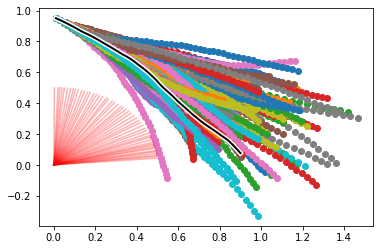

In [10]:
data.plot_inferences([particle['locations'] for particle in particles])

particle weight:  0.9999999900998796


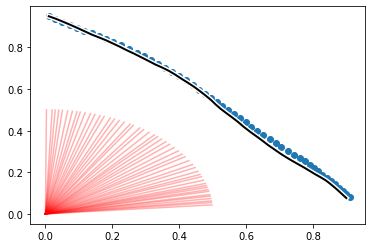

In [11]:
best_idx = np.argmax([particle['weight'] * particle['prior_prob'] for particle in particles])
print('particle weight: ', np.exp(particles[best_idx]['weight']))
data.plot_inferences([particles[best_idx]['locations']])

We can see that SIS correctly identifies a particle that is quite close to the ground-truth trajectory. However, we can also see the two limitations of SIS. 
1. Since we are sampling trajectories from the prior, we end up with many particles that are obviously inconsistent with our measurements. These are a waste of computation. 
2. All but one of the importance weights converge to 0. This means that we effectively only have drawn one sample from $p(x_{0:t}|y_{1:t})$, meaning we only have a very low-resolution picture of the distribution. 
In the next section, we see that the bootstrap filter addresses these issues. 

## The Boostrap Filter
The following function defines the selection step from the boostrap filter algorithm. 

In [12]:
def selection(particles): 
    new_particles = []
    probs = [np.exp(particle["weight"]) for particle in particles]
    
    for _ in range(len(particles)): 
        idx = np.argmax(np.random.multinomial(1, probs))
        new_particles.append(particles[idx])
    return new_particles

This following code snippet performs the boostrap filter algorithm on our data. We have made one modification from the bootstrap filter algorithm described in the accompanying article: instead of applying the selection step at every time step, we only apply it every 10 times steps. The rationale for this is that in our particular case, doing selection at every time step still results in all but one of the importance weights becoming $0$. However, doing selection only every $\Delta t$ steps scales the variance of the log-importance weights at selection time by $1/{\Delta t}$. Setting $t=10$ is sufficient to preserve the diversity of particles. 

In [13]:
better_particles = [{
    "locations": np.expand_dims(x0, axis=0), 
    "velocities": np.expand_dims(v0, axis=0), 
    "weight": np.log(1.0/num_particles), 
    "prior_prob": 0
} for _ in range(num_particles)]

for t, (_, _, yt) in enumerate(data): 
    if t%10==0: 
        better_particles = selection(better_particles)
        better_particles = particle_filter_step(better_particles, yt, selection=True)
        better_particles = normalize_weights(better_particles)
    else: 
        better_particles = particle_filter_step(better_particles, yt, selection=False)
        better_particles = normalize_weights(better_particles)

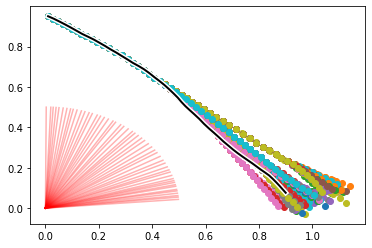

In [14]:
data.plot_inferences([particle['locations'] for particle in better_particles])

As we can see, the bootstrap filter resolves the problems associate with SIS. Namely, 
1. All particles have equal weight. 
2. Since all our particles are informative, we have rich information about $p(x_{0:t}|y_{1:t})$. 